In [395]:
import numpy as np
import shapely
from shapely.geometry import LineString, Point, Polygon
import matplotlib.pyplot as plt

In [1035]:
O = [0, 0]
A = [40, 40]
B = [40, 70]
C = [-40, 70]
D = [-40, 40]
E = [-40, 0]
F = [40, 0]

class dotPair():
    def __init__(self, sPoint, ePoint):
        self.sPoint = sPoint
        self.ePoint = ePoint

class line():
    def __init__(self, sPoint, theta):
        self.sPoint=sPoint
        self.theta = theta
        self.ang = [np.cos(self.theta), np.sin(self.theta)]
        self.c = -self.ang[1] * self.sPoint[0] + self.ang[0] * self.sPoint[1]
        self.abc=[self.ang[1], -self.ang[0], self.c]
        
def ifIntersect(line, seg):
    sFlag = np.sum(np.array(line.abc) * np.array([seg.sPoint[0],seg.sPoint[1],1]))
    eFlag = np.sum(np.array(line.abc) * np.array([seg.ePoint[0],seg.ePoint[1],1]))
    if sFlag * eFlag > 0:
        return False
    else:
        return True

def getCross(line, seg):
    abLine = [line.abc[0],line.abc[1]]
    abDot = [seg.ePoint[1]-seg.sPoint[1], seg.sPoint[0]-seg.ePoint[0]]
    c = np.array([-line.abc[2],seg.ePoint[1]*seg.sPoint[0]-seg.sPoint[1]*seg.ePoint[0]])
    # print(abLine, abDot, c)
    cross = np.linalg.solve(np.array([abLine,abDot]),c)
    # print(cross)
    if (cross[0]-line.sPoint[0]) * line.ang[0] >= 0 and \
        (cross[1]-line.sPoint[1]) * line.ang[1] >= 0:
        if (cross[0] >= -40 and cross[0] <= 40) and \
            (cross[1] >= 0 and cross[1] <= 70):
            return cross
    else:
        return None

def getOffsets(label):
    center = [label[0], label[2]]
    theta = label[-2]
    obj_id = label[-1]
    # [delta_x, delta_z, delta_ry=0, obj_id]
    offsets = [0, 0, 0, obj_id]

    intersect_point = [0, [0, 0]]
    poly = [dotPair(O, A), dotPair(A, B), dotPair(B, C),
            dotPair(C, D), dotPair(D, O)]
    l1 = line(center, theta)
    for i in range(len(poly)):
        if ifIntersect(l1, poly[i]):
            cross = getCross(l1, poly[i])
            if cross is not None:
                intersect_point[0] = i
                intersect_point[1] = cross
      
    # distance between intersect_point and next label center
    inc_theta = 0
    if intersect_point[0] in [0, 4]:
        if theta >= 0:
            inc_theta = np.pi / 4
        else:
            inc_theta = - np.pi / 4
    temp = np.tan(theta + inc_theta) 
    if temp > 10 or temp < -10:
        d = 1 / 2 * label[3]
    else:
        temp_theta = theta + inc_theta
        if temp_theta >= np.pi:
            temp_theta = temp_theta - np.pi
        elif temp_theta >= (np.pi/2):
            temp_theta = temp_theta - np.pi / 2
        elif temp_theta <= - np.pi:
            temp_theta = temp_theta + np.pi
        elif temp_theta <= (-np.pi/2):
            temp_theta = temp_theta + np.pi / 2
        
        if temp_theta >= np.pi / 4:
            temp_theta = np.pi / 2 - temp_theta
        if temp_theta <= - np.pi / 4:
            temp_theta = np.pi / 2 + temp_theta
        d = 1 / 2 * (abs(label[4] * np.tan(temp_theta)) + label[3]) 
    
    offsets[0] = (intersect_point[1][0] - label[0]) + \
                        d * np.cos(np.pi / 2 + theta)
    offsets[1] = (intersect_point[1][1] - label[2]) + \
                        d * np.sin(np.pi / 2 + theta)
    return offsets


def getOffsets2(label):
    center = [label[0], label[2]]
    theta = label[-2]
    obj_id = label[-1]
    # [delta_x, delta_z, delta_ry=0, obj_id]
    offsets = [0, 0, 0, obj_id]

    intersect_point = [0, [0, 0]]
    poly = [dotPair(O, A), dotPair(A, B), dotPair(B, C),
            dotPair(C, D), dotPair(D, O)]
    l1 = line(center, theta)
    sflag = False
    for i in range(len(poly)):
        if ifIntersect(l1, poly[i]):
            cross = getCross(l1, poly[i])
            if cross is not None:
                sflag = True
                intersect_point[0] = i
                intersect_point[1] = cross
    if not sflag:
        return offsets
    x0, y0 = center[0], center[1]
    x1, y1 = intersect_point[1][0], intersect_point[1][1]
    w, l = label[4], label[3]
    if intersect_point[0] == 2:
        if y1-y0 == 0:
            d = l / 2
        else:
            # d = w|x1-x0|/(2|y1-y0|)
            d = w * abs(x1 - x0)/ (2*abs(y1 - y0)) + l / 2
    elif intersect_point[0] in [1, 3]:
        if x1-x0 == 0:
            d = l / 2
        else:
            # d = w|y1-y0|/(2|x1-x0|)
            d = w * abs(y1 - y0)/ (2*abs(x1 - x0)) + l / 2
    elif intersect_point[0] in [0, 4]:
        D2 = (x1 - x0) ** 2 + (y1 - y0) ** 2
        if intersect_point[0] == 0:
            h = abs(x0 - y0) / 2
        else:
            h = abs(x0 + y0) / 2
        if h == 0:
            d = l / 2
        else:
            d = w * np.sqrt(D2 - h ** 2) / (2 * h) + l / 2
    
    if d > l:
        d = l
    
    offsets[0] = (x1 - x0) + d * np.cos(theta)
    offsets[1] = (y1 - y0) + d * np.sin(theta)
    return offsets

def getOffsets3(label):
    center = [label[0], label[2]]
    theta = label[-2]
    obj_id = label[-1]
    # [delta_x, delta_z, delta_ry=0, obj_id]
    offsets = [0, 0, 0, obj_id]
    intersect_point = [0, [0, 0]]
    poly = [dotPair(B, C), dotPair(C, E), 
            dotPair(E, F), dotPair(F, B)]
    l1 = line(center, theta)
    sflag = False
    for i in range(len(poly)):
        if ifIntersect(l1, poly[i]):
            cross = getCross(l1, poly[i])
            if cross is not None:
                sflag = True
                intersect_point[0] = i
                intersect_point[1] = cross
    if not sflag:
        return offsets
    # print(intersect_point)
    x0, y0 = center[0], center[1]
    x1, y1 = intersect_point[1][0], intersect_point[1][1]
    w, l = label[4], label[3]
    if intersect_point[0] in [0, 2]:
        if y1-y0 == 0:
            d = l / 2
        else:
            # d = w|x1-x0|/(2|y1-y0|)
            d = w * abs(x1 - x0)/ (2*abs(y1 - y0)) + l / 2
    elif intersect_point[0] in [1, 3]:
        if x1-x0 == 0:
            d = l / 2
        else:
            # d = w|y1-y0|/(2|x1-x0|)
            d = w * abs(y1 - y0)/ (2*abs(x1 - x0)) + l / 2
    if d > l:
        d = l
    # print(d)
    offsets[0] = (x1 - x0) + d * np.cos(theta)
    offsets[1] = (y1 - y0) + d * np.sin(theta)
    return offsets

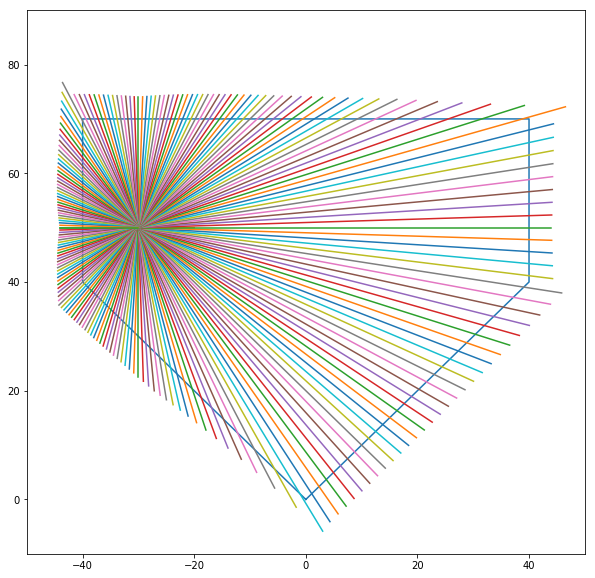

In [1025]:
TOTAL_SEG = 100
dlabel = [-30, 1, 50, 8, 4, 4, 0, 5]
point1 = [dlabel[0], dlabel[2]]
point2 = [dlabel[0] + 10 * np.cos(ltheta + np.pi / 2), 
          dlabel[2] + 10 * np.sin(ltheta + np.pi / 2)]
dpoly = Polygon([O,A,B,C,D,O])
dline = LineString([point1, point2])
plt.figure(figsize=(10,10))
plt.plot(*dpoly.exterior.xy)
plt.plot(*dline.xy)
plt.xlim([-50, 50])
plt.ylim([-10, 90])
for i in range(-TOTAL_SEG, TOTAL_SEG+1):
    ltheta = np.pi * i / TOTAL_SEG 
    dlabel[-2] = ltheta
    offsets = getOffsets2(dlabel)
    point3 = [offsets[0]+point1[0], offsets[1]+point1[1]]
    eline = LineString([point1, point3])
    plt.plot(*eline.xy)
plt.show()

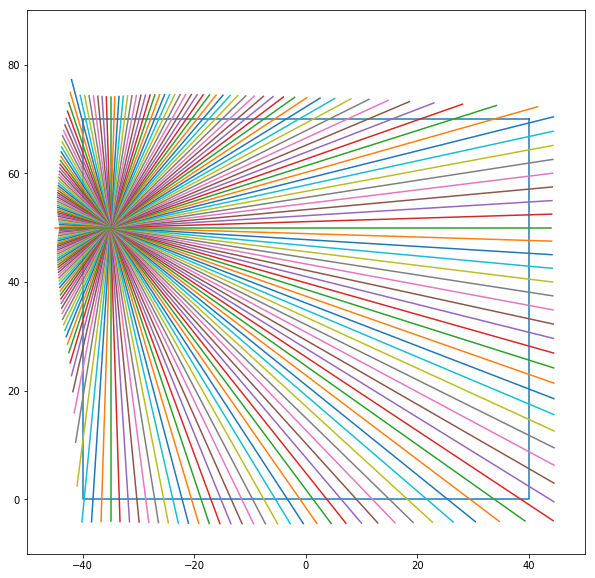

In [1034]:
TOTAL_SEG = 100
dlabel = [-35, 1, 50, 8, 4, 4, 0, 5]
point1 = [dlabel[0], dlabel[2]]
point2 = [dlabel[0] + 10 * np.cos(ltheta), 
          dlabel[2] + 10 * np.sin(ltheta)]
dpoly = Polygon([B,C,E,F,B])
dline = LineString([point1, point2])
plt.figure(figsize=(10,10))
plt.plot(*dpoly.exterior.xy)
plt.plot(*dline.xy)
plt.xlim([-50, 50])
plt.ylim([-10, 90])
for i in range(-TOTAL_SEG, TOTAL_SEG+1):
    ltheta = np.pi * i / TOTAL_SEG 
    dlabel[-2] = ltheta
    offsets = getOffsets3(dlabel)
    point3 = [offsets[0]+point1[0], offsets[1]+point1[1]]
    eline = LineString([point1, point3])
    plt.plot(*eline.xy)
plt.show()

[-0.028916238136094542, 25.619661852972399, 0, 94]


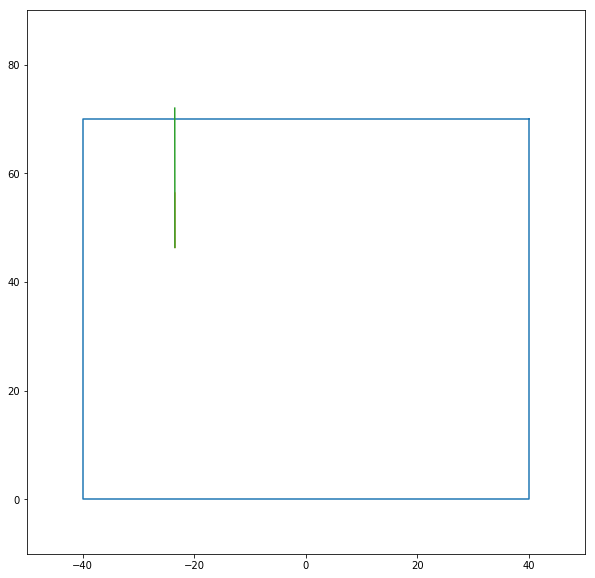

In [1038]:
dlabel = [-23.46224589,3.14603686,46.36482291,
          3.967162,1.6037,1.399088, 1.571925,94]
ltheta = dlabel[-2]
point1 = [dlabel[0], dlabel[2]]
point2 = [dlabel[0] + 10 * np.cos(ltheta), 
          dlabel[2] + 10 * np.sin(ltheta)]
dpoly = Polygon([B,C,E,F,B])
dline = LineString([point1, point2])
plt.figure(figsize=(10,10))
plt.plot(*dpoly.exterior.xy)
plt.plot(*dline.xy)
plt.xlim([-50, 50])
plt.ylim([-10, 90])

offsets = getOffsets3(dlabel)
print(offsets)
point3 = [offsets[0]+point1[0], offsets[1]+point1[1]]
eline = LineString([point1, point3])
plt.plot(*eline.xy)
plt.show()